# Task 2: Exploratory Data Analysis (EDA)

## Financial Inclusion in Ethiopia

This notebook explores patterns, trends, and relationships in Ethiopia’s
financial inclusion data using the enriched dataset produced in Task 1.
The analysis focuses on Access, Usage, infrastructure enablers, and events
that may influence inclusion outcomes.


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [3]:
# Load enriched dataset

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
data_path = PROJECT_ROOT / "data" / "processed" / "ethiopia_fi_unified_data_enriched.csv"




In [4]:
fi_df = pd.read_csv(data_path, parse_dates=["observation_date"])
fi_df.shape

(46, 34)

In [5]:
# Dataset structure overview

fi_df.info()


<class 'pandas.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   record_id            46 non-null     str           
 1   record_type          46 non-null     str           
 2   category             10 non-null     str           
 3   pillar               36 non-null     str           
 4   indicator            46 non-null     str           
 5   indicator_code       46 non-null     str           
 6   indicator_direction  36 non-null     str           
 7   value_numeric        36 non-null     float64       
 8   value_text           10 non-null     str           
 9   value_type           46 non-null     str           
 10  unit                 36 non-null     str           
 11  observation_date     46 non-null     datetime64[us]
 12  period_start         10 non-null     str           
 13  period_end           10 non-null     str        

In [6]:
# Record type distribution

fi_df["record_type"].value_counts()


record_type
observation    33
event          10
target          3
Name: count, dtype: int64

### Record Type Distribution

The dataset consists of observations, events, targets, and modeled records.
Observations represent measured values, events capture major policy and market
developments, and targets reflect official policy goals.


In [7]:
# Records by pillar

fi_df.groupby(["record_type", "pillar"]).size().reset_index(name="count")


,record_type,pillar,count
0,observation,ACCESS,16
1,observation,AFFORDABILITY,1
2,observation,GENDER,4
3,observation,USAGE,12
4,target,ACCESS,2
5,target,GENDER,1


### Records by Pillar

Access and Usage indicators dominate the dataset, while Gender and
Affordability are comparatively underrepresented. This imbalance reflects
both data availability and historical measurement priorities.


In [8]:
# Source types (data credibility)

fi_df["source_type"].value_counts(dropna=False)


source_type
operator            15
survey              10
regulator            7
research             4
policy               3
calculated           2
news                 2
industry_report      1
operator_report      1
regulator_report     1
Name: count, dtype: int64

### Source Types

Most observations originate from surveys and operator reports, with fewer
administrative and modeled sources. This affects temporal frequency and
uncertainty in trend analysis.


In [9]:
# Data quality – confidence levels

fi_df["confidence"].value_counts()


confidence
high      40
medium     6
Name: count, dtype: int64

### Data Confidence Assessment

The majority of records are classified as high confidence, providing a
reliable foundation for exploratory analysis. Medium-confidence records
highlight areas where proxy or inferred data is used.


In [10]:
# Create a Year Column

fi_df["year"] = fi_df["observation_date"].dt.year


### Temporal Feature Engineering

A `year` column is derived from `observation_date` to support
time-based aggregation and trend analysis.


In [11]:
# Overall Year Coverage

fi_df["year"].value_counts().sort_index()


year
2014     1
2017     1
2021     7
2022     1
2023     2
2024    17
2025    15
2028     1
2030     1
Name: count, dtype: int64

### Overall Temporal Coverage

The dataset spans multiple years with uneven distribution.
Recent years contain denser observations, while earlier years
have limited coverage, reflecting evolving data availability
and reporting maturity.


In [12]:
# Temporal Coverage by Record Type

(
    fi_df.groupby(["record_type", "year"])
    .size()
    .reset_index(name="count")
    .sort_values(["record_type", "year"])
)


,record_type,year,count
0,event,2021,2
1,event,2022,1
2,event,2023,1
3,event,2024,3
4,event,2025,3
5,observation,2014,1
6,observation,2017,1
7,observation,2021,5
8,observation,2023,1
9,observation,2024,14


### Temporal Coverage by Record Type

Observations dominate recent years, while events appear as
isolated timestamps corresponding to major policy or market
milestones. Targets are sparse and policy-driven.


In [13]:
# Indicator Coverage Over Time

observations = fi_df[fi_df["record_type"] == "observation"]

indicator_year_counts = (
    observations.groupby(["indicator_code", "year"])
    .size()
    .reset_index(name="count")
)

indicator_year_counts.head()


,indicator_code,year,count
0,ACC_4G_COV,2023,1
1,ACC_4G_COV,2024,1
2,ACC_4G_COV,2025,1
3,ACC_FAYDA,2024,1
4,ACC_FAYDA,2025,2


In [14]:
# Pivot Table: Indicator × Year Matrix

indicator_year_pivot = indicator_year_counts.pivot(
    index="indicator_code",
    columns="year",
    values="count"
).fillna(0)

indicator_year_pivot.head()


year,2014,2017,2021,2023,2024,2025
indicator_code,,,,,,
ACC_4G_COV,0.0,0.0,0.0,1.0,1.0,1.0
ACC_FAYDA,0.0,0.0,0.0,0.0,1.0,2.0
ACC_MM_ACCOUNT,0.0,0.0,1.0,0.0,1.0,0.0
ACC_MOBILE_PEN,0.0,0.0,0.0,0.0,1.0,1.0
ACC_OWNERSHIP,1.0,1.0,3.0,0.0,1.0,0.0


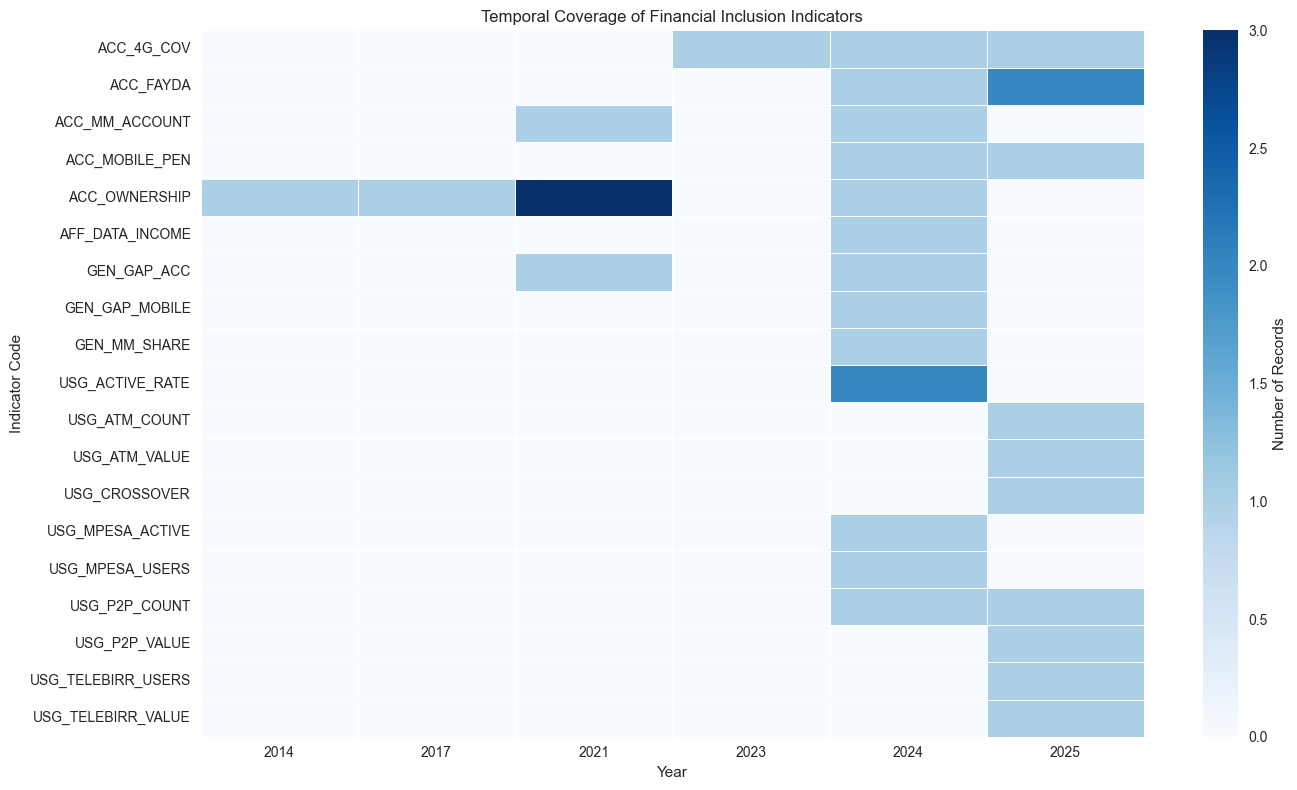

In [15]:
# Heatmap: Temporal Data Density

plt.figure(figsize=(14, 8))
sns.heatmap(
    indicator_year_pivot,
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Records"}
)

plt.title("Temporal Coverage of Financial Inclusion Indicators")
plt.xlabel("Year")
plt.ylabel("Indicator Code")
plt.tight_layout()
plt.show()


### Temporal Coverage Heatmap

The heatmap highlights substantial data sparsity across indicators.
Most indicators have observations in only one or two years, limiting
the feasibility of continuous time-series analysis.

Access indicators show relatively broader coverage, while Usage and
Gender indicators are more fragmented. This constrains causal inference
and emphasizes the need for event-based interpretation.


In [16]:
# Identify Sparse vs Rich Indicators

indicator_coverage_summary = (
    observations.groupby("indicator_code")["year"]
    .nunique()
    .sort_values(ascending=False)
)

indicator_coverage_summary


indicator_code
ACC_OWNERSHIP         4
ACC_4G_COV            3
ACC_FAYDA             2
ACC_MM_ACCOUNT        2
ACC_MOBILE_PEN        2
GEN_GAP_ACC           2
USG_P2P_COUNT         2
GEN_GAP_MOBILE        1
GEN_MM_SHARE          1
USG_ACTIVE_RATE       1
AFF_DATA_INCOME       1
USG_ATM_COUNT         1
USG_ATM_VALUE         1
USG_MPESA_ACTIVE      1
USG_CROSSOVER         1
USG_MPESA_USERS       1
USG_P2P_VALUE         1
USG_TELEBIRR_USERS    1
USG_TELEBIRR_VALUE    1
Name: year, dtype: int64

### Indicator Temporal Depth

Most indicators have observations in fewer than three distinct years.
Only a small subset supports limited longitudinal comparison.
This reinforces the need to interpret trends cautiously and
supplement numeric analysis with contextual events.


## Data Quality Assessment

- **Temporal sparsity:** Most indicators are reported in only one year,
  preventing robust trend analysis.

- **Pillar imbalance:** Access indicators are overrepresented, while
  affordability and gender indicators are limited.

- **Missing values:** Several fields (region, category, notes) contain
  significant null values, limiting segmentation analysis.

- **Event-heavy structure:** Events provide context but cannot be used
  for numeric comparison or modeling.

- **Limited geographic granularity:** Most records lack regional detail,
  constraining sub-national analysis.


## Key Insights

1. **Financial inclusion data is heavily skewed toward recent years**
   - 2024 (17 records) and 2025 (15 records) dominate the dataset,
     while pre-2020 years contain very limited observations.
   - This introduces recency bias and limits long-term trend analysis.

2. **Access indicators are the most consistently reported**
   - ACCESS accounts for 16 observation records, compared to
     12 for USAGE and only 4 for GENDER.
   - This suggests policy and data collection prioritize access
     over usage quality or gender equity.

3. **Most indicators lack longitudinal depth**
   - The majority of indicators appear in only one year.
   - Only ACC_OWNERSHIP, ACC_4G_COV, and ACC_FAYDA span multiple years,
     limiting reliable time-series modeling.

4. **Event data aligns with major sector milestones**
   - Events cluster around telecom liberalization (2021–2025),
     mobile money launches, and payment infrastructure reforms.
   - These events provide essential context for interpreting indicator changes.

5. **High confidence dominates but hides structural gaps**
   - 40 out of 46 records are labeled high confidence.
   - However, confidence does not compensate for sparse coverage,
     especially across gender and affordability indicators.
